In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# 2. Data Loading & Cleaning
df = pd.read_csv('amazon_products_sales_data_cleaned.csv')
# Select features and target
# We use log transformation for Price/Reviews to handle skewness (based on Week 3 insights)
model_df = df.dropna(subset=['current/discounted_price', 'rating', 'number_of_reviews', 'is_sponsored', 'is_best_seller']).copy()
model_df['log_price'] = np.log1p(model_df['current/discounted_price'])
model_df['log_reviews'] = np.log1p(model_df['number_of_reviews'])
model_df['is_sponsored'] = model_df['is_sponsored'].astype(int)
model_df['is_best_seller'] = model_df['is_best_seller'].astype(int) # Target

X = model_df[['log_price', 'log_reviews', 'rating', 'is_sponsored']]
y = model_df['is_best_seller']

In [3]:
# 3. Train/Test Split
# We use 'stratify=y' because Best Sellers are rare; this ensures both sets have the same % of best sellers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

# 4. Model Selection & Hyperparameter Tuning
# We use Random Forest for its ability to handle non-linear relationships
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Grid Search to find the best parameters (Optimization)
param_grid = {
    'n_estimators': [100, 200],      # Number of trees
    'max_depth': [10, 20, None],     # Max depth of tree
    'min_samples_split': [2, 5]      # Min samples to split a node
}

print("\nStarting Hyperparameter Tuning (GridSearchCV)...")
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")



Training Set Shape: (24269, 4)
Test Set Shape: (6068, 4)

Starting Hyperparameter Tuning (GridSearchCV)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters Found: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}



--- Model Performance Metrics ---
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5737
           1       0.43      0.63      0.51       331

    accuracy                           0.93      6068
   macro avg       0.70      0.79      0.74      6068
weighted avg       0.95      0.93      0.94      6068


--- Feature Importance ---
log_reviews     0.372944
log_price       0.329175
rating          0.230853
is_sponsored    0.067028
dtype: float64


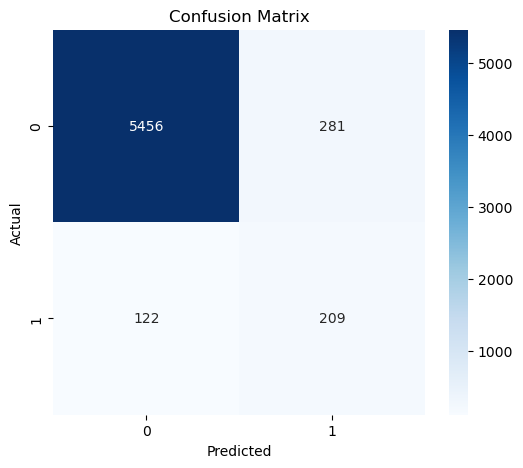

In [5]:
# 5. Evaluation
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance Metrics ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion Matrix.png')


# Feature Importance
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n--- Feature Importance ---")
print(importances)